# Reddit "Legal Advice"

In [1]:
import os
import time
import tiktoken
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from dotenv import load_dotenv
from IPython.display import Markdown, display

In [2]:
from token_catcher import Usage

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
df = pd.read_parquet("../legal_reddit_df_with_embeddings.parquet")

In [5]:
encoding = tiktoken.get_encoding('cl100k_base')

In [6]:
df['token_count'] = df['body'].apply(lambda x: len(encoding.encode(x)))

In [7]:
print(df.shape)
df.head(2)

(9887, 9)


,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count
0,1588353888,https://www.reddit.com/r/legaladvice/comments/...,gbmcb0,The title says most of it. I just heard back f...,My former employer fired everyone when they ha...,employment,5,"[-0.009678525544039132, -0.030654356001073007,...",156
1,1575490057,https://www.reddit.com/r/legaladvice/comments/...,e64ze3,"In Maine, my landlord (commercial property man...",Landlord is updating snow removal policies and...,housing,7,"[-0.014251169117179163, -0.0037985407615359528...",218


In [8]:
df.token_count.describe()

count    9887.000000
mean      281.192070
std       269.636493
min         1.000000
25%       120.000000
50%       209.000000
75%       350.000000
max      8513.000000
Name: token_count, dtype: float64

In [9]:
print(f"df shape before: {df.shape}")
df = df[df['token_count']<1024]
print(f"df shape after: {df.shape}")

df shape before: (9887, 9)
df shape after: (9677, 9)


In [10]:
df_dedup = df.drop_duplicates(subset='body', keep='last')
df_dedup.reset_index(inplace=True, drop=True)

In [11]:
Markdown(f"""
| Name | Count |
| --- | --- |
| N Original Rows: | {len(df):,} |
| N Dups: | {len(df) - len(df_dedup)} |
| N Rows in Deduped df: | {len(df_dedup):,} |
""")



| Name | Count |
| --- | --- |
| N Original Rows: | 9,677 |
| N Dups: | 54 |
| N Rows in Deduped df: | 9,623 |


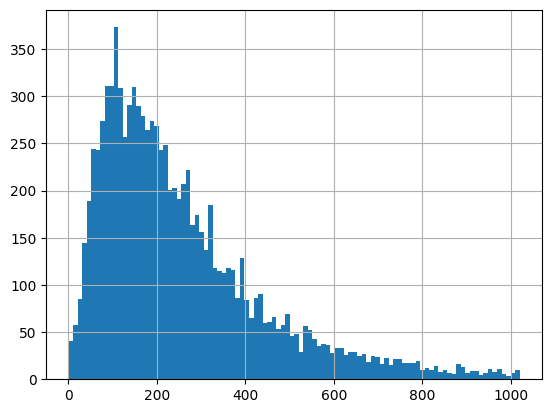

In [12]:
df.token_count.hist(bins=100);

In [13]:
from langchain import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)


system_template = "You're a legal journalist. You're helping me write a concise topic title for legal questions."
human_template = "Using the following legal questions, write a concise tag line.\n\nQUESTIONS:{body}\n\nTAG LINE:"

prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template(human_template),
    ],
    input_variables=["body"],
)
    
chain = LLMChain(
    llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo"), prompt=prompt, verbose=False
)

In [14]:
list_to_chain = df_dedup[["body"]].to_dict('records')
len(list_to_chain)

9623

In [15]:
usage = Usage()

In [16]:
from tqdm import tqdm
batch_size = 1
results = []

start_time = time.time()

for i, batch_start in tqdm(enumerate(range(0, len(list_to_chain), batch_size)), total=len(list_to_chain)//batch_size):
    batch = list_to_chain[batch_start: batch_start + batch_size]
    processed_batch = chain.run(batch)
    results.append(processed_batch)

final_time = time.time() - start_time
print(f"Total elapsed time: {final_time:.2f} seconds")

100%|██████████| 9623/9623 [3:22:50<00:00,  1.26s/it]    

Total elapsed time: 12170.79 seconds


In [17]:
usage.total_tokens()/1000*0.002

6.483348

In [18]:
# Check if 'results' length is same as the original data
assert len(results) == len(df_dedup), "Length of the result does not match with the original data"

In [19]:
results[0]

'"Legal implications of mass termination and potential for wrongful termination class-action lawsuit at Cafe Mooby"'

In [1]:
# df_dedup['llm_title'] = pd.DataFrame(results)

In [21]:
df_dedup.head(2)

,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title
0,1588353888,https://www.reddit.com/r/legaladvice/comments/...,gbmcb0,The title says most of it. I just heard back f...,My former employer fired everyone when they ha...,employment,5,"[-0.009678525544039132, -0.030654356001073007,...",156,"""Legal implications of mass termination and po..."
1,1575490057,https://www.reddit.com/r/legaladvice/comments/...,e64ze3,"In Maine, my landlord (commercial property man...",Landlord is updating snow removal policies and...,housing,7,"[-0.014251169117179163, -0.0037985407615359528...",218,"""Unforeseen snow removal policy changes and po..."


In [ ]:
# df_dedup.to_parquet("legal_reddit_df_with_titles.parquet")

In [5]:
df = pd.read_parquet("legal_reddit_df_with_titles.parquet")

In [6]:
print(df.shape)
df.head(2)

(9623, 10)


,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title
0,1588353888,https://www.reddit.com/r/legaladvice/comments/...,gbmcb0,The title says most of it. I just heard back f...,My former employer fired everyone when they ha...,employment,5,"[-0.009678525544039132, -0.030654356001073007,...",156,"""Legal implications of mass termination and po..."
1,1575490057,https://www.reddit.com/r/legaladvice/comments/...,e64ze3,"In Maine, my landlord (commercial property man...",Landlord is updating snow removal policies and...,housing,7,"[-0.014251169117179163, -0.0037985407615359528...",218,"""Unforeseen snow removal policy changes and po..."
